In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [273]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphs and charts
import pandas_profiling # generating Profile Report
from sklearn.model_selection import train_test_split
import numpy as np

import bq_helper # accessing bigQuery database

import sklearn
from sklearn.model_selection import train_test_split # data splitting
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression # Linear model
from sklearn.metrics import mean_squared_error
import wordcloud
from flask import Flask, render_template, request, json
import json
import pandas as pd

# **Accessing the Dataset**
   * Accessing the required dataset from BigQuery
   
### About '*bq_helper*'
   * <p style='text-align: justify;'> bq_helper package simplifies common read-only tasks in BigQuery by dealing with object references and unpacking result objects into pandas dataframes.</p>
   * <p style='text-align: justify;'> It currently only works here on Kaggle as it does not have any handling for the BigQuery authorization functions that Kaggle handles behind the scenes. </p>
   * <p style='text-align: justify;'>bq_helper requires the creation of one BigQueryHelper object per dataset. Let's make one now. We'll need to pass it two arguments: </p>
      1) The name of the BigQuery project, which on Kaggle should always be bigquery-public-data  
      2) The name of the dataset, which can be found in the dataset description  

In [274]:
stackoverflow = bq_helper.BigQueryHelper("bigquery-public-data","stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [4]:
stackoverflow.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [275]:
#stackoverflow.head("posts_questions")

In [7]:
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('test.html')

@app.route('/test')
def test():
    return render_template('test.html')

@app.route('/filter', methods=['POST'])
def filter():
    query1 = """select tags from `bigquery-public-data.stackoverflow.posts_questions` LIMIT 100000"""
    df = stackoverflow.query_to_pandas(query1)
    llist = df['tags'].to_list()
    new_list = [i.split('|') for i in llist]
    flat_list = []
    for sublist in new_list:
        for item in sublist:
            flat_list.append(item)
    #new_list.append(i.split('|'))
    
    print(flat_list)
    

In [8]:
import re
#list_of_tags = stackoverflow.to_list('tags')
query1 = """select tags from `bigquery-public-data.stackoverflow.posts_questions` LIMIT 100000"""
df = stackoverflow.query_to_pandas(query1)
llist = df['tags'].to_list()
print(llist[0:10])
new_list = [i.split('|') for i in llist]
flat_list = []
for sublist in new_list:
    for item in sublist:
        flat_list.append(item)
    #new_list.append(i.split('|'))
print("=======================")
print(new_list[0:10])
print("++++++++++++++++")
print(flat_list[0:10])
#print(tags)

['firebase|permissions', 'webpack|webpack-4', 'flutter|dart|face-detection|firebase-mlkit', 'passenger|passenger-apache', 'python-3.x|django-rest-framework|celery|django-celery', 'joomla', 'tabula-py', 'formula', 'r|mlp', 'plugins|tags|anchor']
[['firebase', 'permissions'], ['webpack', 'webpack-4'], ['flutter', 'dart', 'face-detection', 'firebase-mlkit'], ['passenger', 'passenger-apache'], ['python-3.x', 'django-rest-framework', 'celery', 'django-celery'], ['joomla'], ['tabula-py'], ['formula'], ['r', 'mlp'], ['plugins', 'tags', 'anchor']]
++++++++++++++++
['firebase', 'permissions', 'webpack', 'webpack-4', 'flutter', 'dart', 'face-detection', 'firebase-mlkit', 'passenger', 'passenger-apache']


In [276]:
#stackoverflow.table_schema("posts_questions")

## Data Pre-processing :
* Removing irrelevant data
* Querying the year and the number of posts per year from the '*posts_questions*' table

## Number of posts for first 100000 tags

# Current Trends:

## Total number of Posts Per year between 2008 and current year 2020

In [277]:
queryx = """select EXTRACT(year FROM creation_date) AS year, COUNT(*) AS posts 
        from `bigquery-public-data.stackoverflow.posts_questions`
        where extract(year from creation_date) >= 2008 and extract(year from creation_date) < 2021
        group by year
        order by year
        """

PostsCount = stackoverflow.query_to_pandas(queryx)
print(PostsCount)

    year    posts
0   2008    57924
1   2009   342540
2   2010   692208
3   2011  1192677
4   2012  1633858
5   2013  2046718
6   2014  2152753
7   2015  2206658
8   2016  2209585
9   2017  2125712
10  2018  1903069
11  2019  1886780
12  2020  1644173


## Common function for CURRENT TRENDS and COMPARATIVE ANALYSIS :

In [263]:
def CurrentTrends(dfall, labels = None, title="Current Trends", **kwargs):
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    
    if labels==None:
        labels = dfall    #the keywords list
        
    l = len(dfall)
    ###### for every tag, execute the query separately
    for i in range(l):
        query2 = dfall[i]    # dfall = ['hadoop','spark','hive']
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        Posts.rename(columns = {'posts':dfall[i]}, inplace = True) 
        df.append(Posts)
        

    trend = pd.DataFrame(df[0])
    trend = trend.set_index('year')
    #print(trend)
    
    
    if(l>1):
        for i in range(1,l):
            trend = pd.merge(trend, df[i], how='outer', on = 'year')
            trend = trend.set_index('year')
            trend = trend.fillna(0)
    #print("trend", trend)
    curr_trendsjson = trend.to_json(orient="index")
    
    #parsed = json.loads(curr_result1)
    #json.dumps(parsed, indent=4)
    #print(trend)
    
    return curr_trendsjson
    
    ''''
    
    trend.plot(kind='line')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Posts %', fontsize=15)
    y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
    plt.xticks(y_pos,fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title)
    plt.legend(labels, loc=[1.0,0.5])
    plt.show()
    '''

In [278]:
## For testing purposes: 
curr_trendsjson = CurrentTrends(['hadoop','python','hive','scala'])
curr_trendsjson      #json object for current trends

'{"2009":{"hadoop":0.1225744078,"python":22.8091982598,"hive":0.1674608107,"scala":1.4260064913},"2010":{"hadoop":0.0934197466,"python":8.0454837391,"hive":0.0575115315,"scala":0.695101302},"2011":{"hadoop":0.153566558,"python":6.221395881,"hive":0.0606754039,"scala":0.6798534545},"2012":{"hadoop":0.228142238,"python":5.5900298237,"hive":0.0700105729,"scala":0.4990454247},"2013":{"hadoop":0.3027190857,"python":6.2461364452,"hive":0.089297846,"scala":0.5510270782},"2014":{"hadoop":0.3082495976,"python":6.0525192039,"hive":0.1011863872,"scala":0.5345631396},"2015":{"hadoop":0.3506208097,"python":6.8528995198,"hive":0.1319705512,"scala":0.6226910379},"2016":{"hadoop":0.3133698108,"python":7.8674176062,"hive":0.1590640688,"scala":0.6876915227},"2017":{"hadoop":0.2613612964,"python":9.6674262361,"hive":0.1719779959,"scala":0.63536818},"2018":{"hadoop":0.1770700829,"python":10.9414633779,"hive":0.1598052794,"scala":0.5557196836},"2019":{"hadoop":0.1269002858,"python":14.3693160889,"hive":0.1

## Current Trends for merging with future trend :

In [279]:
def CurrentTrends_merge(dfall, labels = None, title="Current Trends", **kwargs):
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    
    if labels==None:
        labels = dfall    #the keywords list
        
    l = len(dfall)
    ###### for every tag, execute the query separately
    for i in range(l):
        query2 = dfall[i]    # dfall = ['hadoop','spark','hive']
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        Posts.rename(columns = {'posts':dfall[i]}, inplace = True) 
        df.append(Posts)
        
    trend = pd.DataFrame(df[0])
    trend = trend.set_index('year')
    
    if(l>1):
        for i in range(1,l):
            trend = pd.merge(trend, df[i], how='outer', on = 'year')
            trend = trend.set_index('year')
            trend = trend.fillna(0)
    
    return trend


In [280]:
## For testing Purposes :
curr_trendmerge = CurrentTrends_merge(['html','kubernetes'])
curr_trendmerge

,html,kubernetes
year,,
2009,18.437953,0.000000
2010,7.502481,0.000000
2011,7.538486,0.000000
2012,6.867073,0.000000
2013,7.446547,0.001726
2014,6.865626,0.013137
2015,6.460240,0.117017
2016,6.032969,0.150083
2017,5.573083,0.206444


## Future Trends :

In [281]:
def FutureTrends(dfall, labels = None, title="Trends in Technologies in ", **kwargs):

    #plt.figure(figsize=(20,10))
    
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    new = []
    l = len(dfall)
    years = [2021, 2022, 2023]    
    
    if (labels==None):
        labels = dfall
        
    for i in range(l):
        query2 = dfall[i]
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        
        X_train=Posts['year'].values.reshape(-1,1)
        y_train=Posts['posts'].values.reshape(-1,1)
        reg=LinearRegression()
        
        X_test = [[2021], [2022], [2023]]     #hardcoded 3 years
        reg.fit(X_train,y_train)
        predictions = reg.predict(X_test)
        
        dummy = pd.DataFrame(columns = ['year', labels[i]])
        dummy['year']= years
        dummy[labels[i]] = predictions
        
        new.append(dummy)
        #predictions.reshape((1,len(X_test))
    
    trendfuture = pd.DataFrame(new[0])            #first keyword data + predictions
    trendfuture = trendfuture.set_index('year')
    
    if(l>1):                  # if more than 1 keyword
        for i in range(1,l):
            #print()
            trendfuture = pd.merge(trendfuture, new[i], how='outer', on = 'year')
            trendfuture = trendfuture.set_index('year')
    #print(trendfuture)
    
    curr_trendmerge = CurrentTrends_merge(labels)
    
    #print(curr_trendmerge)
    final = pd.concat([curr_trendmerge, trendfuture])
    print(final)
    
    final.plot(kind='line')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Posts %', fontsize=15)
    y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
    plt.xticks(y_pos,fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(title)
    plt.legend(labels, loc=[1.0,0.5])
    plt.show()

## Converting to JSON :

    future_trendsjson = final.to_json(orient="index")
    
    #parsed = json.loads(curr_result1)
    #json.dumps(parsed, indent=4)
    
    return future_trendsjson
    

           html  kubernetes
year                       
2009  18.437953    0.000000
2010   7.502481    0.000000
2011   7.538486    0.000000
2012   6.867073    0.000000
2013   7.446547    0.001726
2014   6.865626    0.013137
2015   6.460240    0.117017
2016   6.032969    0.150083
2017   5.573083    0.206444
2018   4.422518    0.365952
2019   4.492270    0.486540
2020   3.960133    0.431784
2021   2.149741    0.552688
2022   1.383043    0.626266
2023   0.616345    0.699845


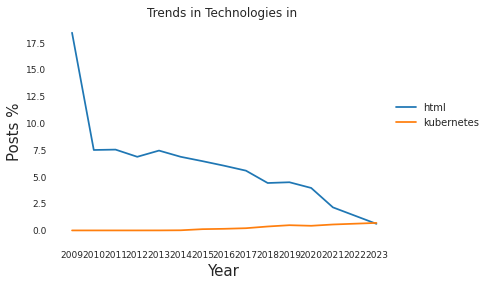

'{"2009":{"html":18.43795318,"kubernetes":0.0},"2010":{"html":7.502481462,"kubernetes":0.0},"2011":{"html":7.5384855419,"kubernetes":0.0},"2012":{"html":6.8670729795,"kubernetes":0.0},"2013":{"html":7.4465467623,"kubernetes":0.0017264001},"2014":{"html":6.8656258459,"kubernetes":0.0131371519},"2015":{"html":6.4602395166,"kubernetes":0.1170168504},"2016":{"html":6.0329693138,"kubernetes":0.1500825454},"2017":{"html":5.5730827282,"kubernetes":0.2064438892},"2018":{"html":4.4225181963,"kubernetes":0.3659517335},"2019":{"html":4.4922701174,"kubernetes":0.4865397935},"2020":{"html":3.9601331369,"kubernetes":0.4317841732},"2021":{"html":2.1497414758,"kubernetes":0.5526880107},"2022":{"html":1.3830430005,"kubernetes":0.626266387},"2023":{"html":0.6163445253,"kubernetes":0.6998447633}}'

In [282]:
future = (FutureTrends(['html','kubernetes']))
future

### Testing model :

In [ ]:
q1="select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%python%' group by year order by year"
ans = stackoverflow.query_to_pandas(q1)
years = ans['year'].values.reshape(-1,1)
posts = ans['posts'].values.reshape(-1,1)
years.shape, posts.shape

In [ ]:
impport numpy as np

In [ ]:
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(years,posts, test_size=0.30)
    lr = LinearRegression()
    z = lr.fit(X_train, y_train)
    #print(z.score(X_train,y_train))
    print("Epoch : ", i)
    predictions_train = z.predict(X_train)
    print('Score: %.2f' % z.score(X_train, y_train))
    rms_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    print ('Training set RMSE: %.2f' % rms_train)
    
    

In [ ]:
predictions = z.predict(X_test)


In [ ]:
X_train.shape

In [ ]:

mse = mean_squared_error(y_test, predictions)
mse

In [ ]:

mse = mean_squared_error(y_test, predictions)
mse

In [ ]:
#stackoverflow.head("posts_questions")

query1 = "select EXTRACT(date FROM creation_date) AS Date, count(id) AS PostsCnt from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 group by date order by date"
#query3 = "%' group by year oder by year"
timeseries_python = stackoverflow.query_to_pandas(query1)
timeseries_python

In [ ]:
query3 = """WITH historic_views AS (
  SELECT *, '201703' q
  FROM `fh-bigquery.stackoverflow_archive.201703_posts_questions` 
  UNION ALL
  SELECT *, '201706' q 
  FROM `fh-bigquery.stackoverflow_archive.201706_posts_questions` 
  UNION ALL
  SELECT *,  '201709' q 
  FROM `fh-bigquery.stackoverflow_archive.201709_posts_questions` 
  UNION ALL
  SELECT *, '201712' q 
  FROM `fh-bigquery.stackoverflow_archive.201712_posts_questions` 
  UNION ALL
  SELECT *, '201803' q 
  FROM `fh-bigquery.stackoverflow_archive.201803_posts_questions` 
  UNION ALL
  SELECT *, '201806' q 
  FROM `fh-bigquery.stackoverflow_archive.201806_posts_questions` 
), top_tags AS (
    SELECT value FROM UNNEST((
       SELECT APPROX_TOP_COUNT(tags, 5000)top  
       FROM `fh-bigquery.stackoverflow_archive.201803_posts_questions` 
       WHERE NOT tags LIKE '%|%'))
    WHERE count > 10
), views_per_tag AS (
  SELECT tag, COUNTIF(DATE(creation_date) BETWEEN DATE_SUB(PARSE_DATE('%Y%m',  q), INTERVAL 3 MONTH) AND PARSE_DATE('%Y%m',  q)) questions
    , SUM(view_count) views_cum, PARSE_DATE('%Y%m',  q) q
  FROM historic_views, UNNEST(SPLIT(tags, '|')) tag
  GROUP BY tag, q
), views_per_q AS (
  SELECT *, views_cum - LAG(views_cum, 1) OVER(PARTITION BY tag ORDER BY q) views
  FROM views_per_tag
), percents AS (
  SELECT *
    , 100*views/SUM(views) OVER(PARTITION BY q) views_percent
    , 100*questions/SUM(questions) OVER(PARTITION BY q) questions_percent
  FROM views_per_q
  WHERE views IS NOT null
  AND tag IN (SELECT value FROM top_tags)
)

SELECT *
FROM percents
"""
abc = stackoverflow.query_to_pandas(query3)
abc

In [ ]:

abc  = stackoverflow.query_to_pandas(query3)
print(abc[0:10000])